In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 52.4MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.85MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.11MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



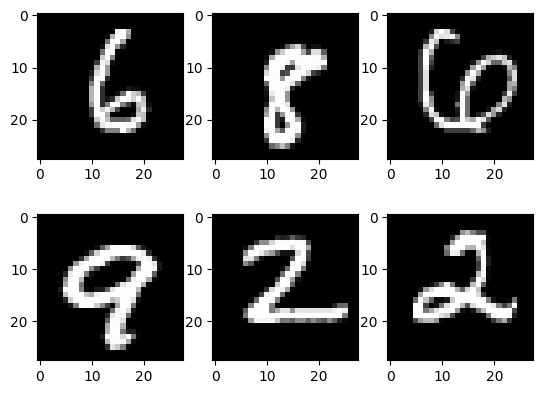

In [ ]:
# Visualize a few examples from the dataset
examples = iter(train_loader)
images, _ = next(examples)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
plt.show()

In [ ]:
# Flatten the input for fully connected layers
input_dim = 28 * 28  # MNIST image size

# Define layer to flatten image
flatten = nn.Flatten()
sample_input = images[0]
flattened = flatten(sample_input)
print(f"Flattened shape: {flattened.shape}")  # Expect (784,)

Flattened shape: torch.Size([1, 784])


In [ ]:
# Linear transformation to map input to hidden representation
hidden_dim = 256
fc1 = nn.Linear(input_dim, hidden_dim)
hidden_output = fc1(flattened)
print(f"Hidden shape after first layer: {hidden_output.shape}")

Hidden shape after first layer: torch.Size([1, 256])


Important concept:
 - For text, we output a ategorical distribution (prob. of each word)
 - For embeddings (regression)  we predict a gaussian distribution ($\mu,
 \sigma^2$)
 - The mean the most probable (argmax) but we can also sample randomly

 Later (when computing loss) the $\log(\sigma^2)$  is more useful than $\sigma$. Predciting it is comnvenient.

In [ ]:
# Define layers for mean and log-variance
latent_dim = 20
fc_mu = nn.Linear(hidden_dim, latent_dim)
fc_logvar = nn.Linear(hidden_dim, latent_dim)

mu = fc_mu(hidden_output)
logvar = fc_logvar(hidden_output)
print(f"Mean shape: {mu.shape}, Logvar shape: {logvar.shape}")  # Expect (20,)

Mean shape: torch.Size([1, 20]), Logvar shape: torch.Size([1, 20])


In [ ]:
def sample_latent(mu, logvar):
    std = torch.exp(0.5 * logvar)   # differentiable
    epsilon = torch.randn_like(std) # NOT differentiable
    z = mu + epsilon * std  # mu, z, and std are differentiable
    return z

z = sample_latent(mu, logvar)
print(f"Sampled latent vector shape: {z.shape}")  # Expect (20,)

Sampled latent vector shape: torch.Size([32, 20])


In [ ]:
# Define decoder to map latent vector to hidden dimension
fc2 = nn.Linear(latent_dim, hidden_dim)
hidden_decoded = fc2(z)
print(f"Hidden decoded shape: {hidden_decoded.shape}")

Hidden decoded shape: torch.Size([1, 256])


Reconstructed image shape: torch.Size([28, 28])


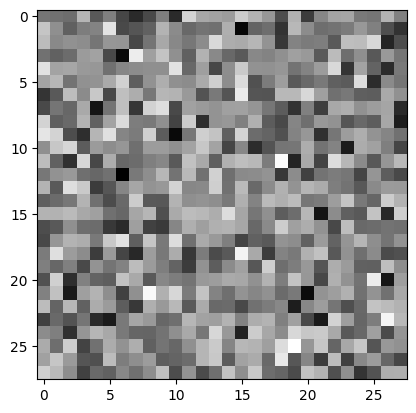

In [ ]:
# Define output layer to reconstruct the original image dimensions
fc3 = nn.Linear(hidden_dim, input_dim)
sigmoid = nn.Sigmoid()
reconstructed_flat = sigmoid(fc3(hidden_decoded))
reconstructed_img = reconstructed_flat.view(28, 28)  # Reshape back to image
print(f"Reconstructed image shape: {reconstructed_img.shape}")  # Expect (28, 28)

plt.imshow(reconstructed_img.detach().numpy(), cmap='gray')
plt.show()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = self.flatten(x)
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = torch.relu(self.fc2(z))
        reconstruction = self.sigmoid(self.fc3(h))
        return reconstruction.view(-1, 1, 28, 28)

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = sample_latent(mu, logvar)
        return self.decoder(z), mu, logvar

In [ ]:
# Define VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    # How well do we reconstruct the (binary) input image
    reconstruction_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') # sum->728 times bigger then mean :)

    # KL divergence measures how well one distribution approximates another
    # -> this is the special case for N(mu, var) vs N(0,1)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # We aren't using weights, often one would scale one of these up or down
    return reconstruction_loss + kl_divergence

In [ ]:
vae = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    for images, _ in train_loader:
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 154.1061
Epoch 2, Loss: 119.3728
Epoch 3, Loss: 113.8911
Epoch 4, Loss: 111.5320
Epoch 5, Loss: 110.0622


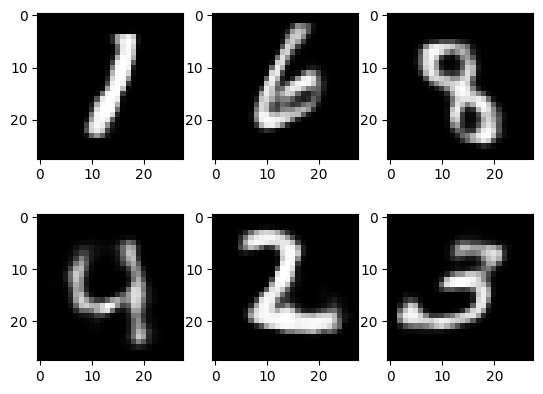

In [ ]:
vae.eval()
examples = iter(train_loader)
images, _ = next(examples)
with torch.no_grad():
    # We do not care about mu, logvar here. A random sample is fine.
    reconstructed, _, _ = vae(images.view(-1, input_dim))
    reconstructed = reconstructed.view(-1, 28, 28)

# Plot original vs. reconstructed images
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(reconstructed[i], cmap='gray')
plt.show()

Visualize Random Embeddings

In [ ]:
# Set the number of samples and latent dimension
num_samples = 10

# Generate random latent vectors
random_latents = torch.randn(num_samples, latent_dim)
print(f"Random latent vectors shape: {random_latents.shape}")


Random latent vectors shape: torch.Size([10, 20])


In [ ]:
# Pass random latents through the VAE decoder to generate images
vae.eval()
with torch.no_grad():
    decoded_images = vae.decoder(random_latents).view(-1, 28, 28)
print(f"Decoded images shape: {decoded_images.shape}")

Decoded images shape: torch.Size([10, 28, 28])


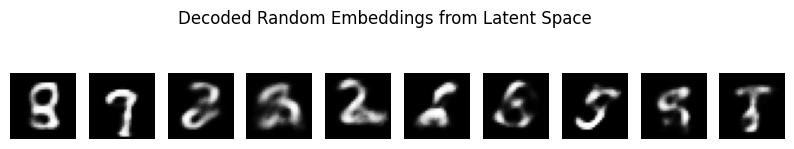

In [ ]:
# Visualize the decoded images
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(decoded_images[i].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("Decoded Random Embeddings from Latent Space")
plt.show()

Embed the images and visualize the embeddings

In [ ]:
latents = []
labels = []

# Loop through the data loader to collect latent representations
vae.eval()
with torch.no_grad():
    for images, targets in train_loader:
        images = images.view(-1, 28 * 28)  # Flatten the images
        mu, _ = vae.encoder(images)  # Only use mean for visualization
        latents.append(mu)
        labels.extend(targets.numpy())

# Stack latents into a single tensor
# -> right now it is a list of 1x20 tensors
latents = torch.cat(latents).cpu().numpy()
labels = np.array(labels)
print(f"Latent representations shape: {latents.shape}")
print(f"Labels shape: {labels.shape}")


Latent representations shape: (60000, 20)
Labels shape: (60000,)


In [ ]:
%pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
# Import UMAP and reduce dimensionality to 2D for visualization
import umap

umap_reducer = umap.UMAP(n_components=2, random_state=42)
latent_2d = umap_reducer.fit_transform(latents)
print(f"2D UMAP projection shape: {latent_2d.shape}")  # Takes >1m to run


2D UMAP projection shape: (60000, 2)


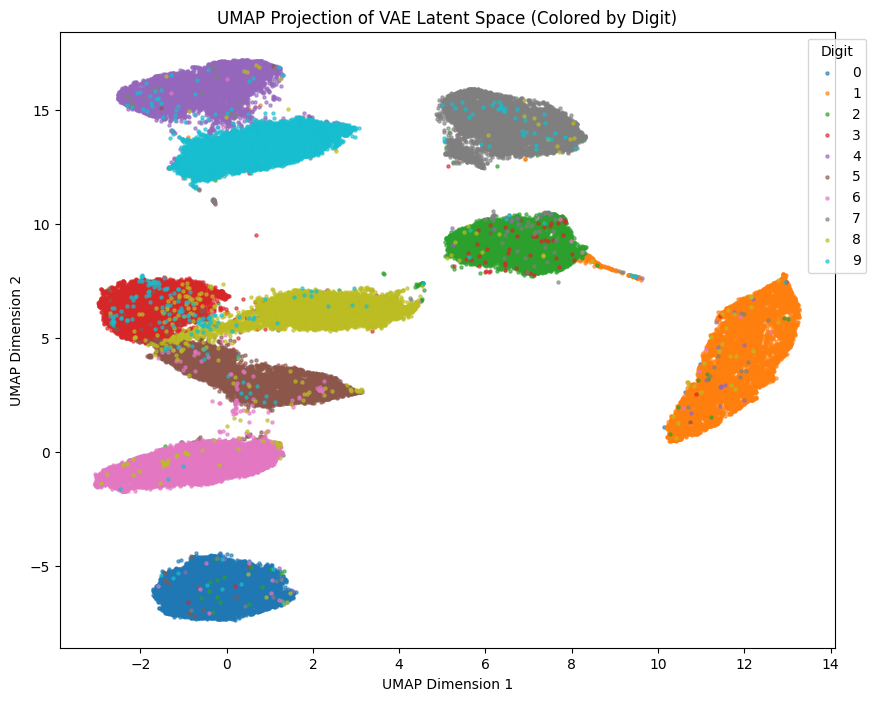

In [ ]:
plt.figure(figsize=(10, 8))
for digit in range(10):
    indices = labels == digit
    plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1], label=str(digit), s=5, alpha=0.6)

plt.title("UMAP Projection of VAE Latent Space (Colored by Digit)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Digit", loc="best", bbox_to_anchor=(1.05, 1))
plt.show()


**POSSIBLE** lab extensions:
1.  Can you replace MNIST with a similar dataset FashionMNIST?
2. Can you identify a colir image dataset?
3.  What heppens if you increase the KL divergence term?


